# I'm Something of a Painter Myself
In this Kaggle competition, we are tasked with creating a Generative Adversarial Network (GAN) that generates images in the style of Monet from target images. This implementation will introduce the **CycleGAN** Model: an architecture that learns the mappings between two domains (images). The primary goal of CycleGAN is to learn mappings between two domains, $X$ and $Y$, in such a way that an image from one domain can be translated into the other domain while preserving the key characteristics of the original image. 

Because of the nature of the CycleGAN, it has two generators ($G$ and $F$) and two discriminators ($D_X$ and $D_Y$), working in pairs for both domains, while a normal GAN only has one generator and one discriminator. A standard GAN also focuses solely on the adversarial loss, aiming to make generated images indistinguishable from real images, while CycleGAN combines adversarial losses with **cycle consistency** loss to ensure not only realism but also that the image can be reverted to its original form after translation:

$$
\begin{aligned}
\mathcal{L}(G, F, D_X, D_Y) &= \mathcal{L}_{GAN}(G, D_Y, X, Y) + \mathcal{L}_{GAN}(F, D_X, Y, X) + \lambda \mathcal{L}_{cyc}(G, F)
\end{aligned}
$$

**where:**

$$
\begin{aligned}
\mathcal{L}_{GAN}(G, D_Y, X, Y) &= \mathbb{E}_{y \sim p_{data}(y)} [\log D_Y(y)] + \mathbb{E}_{x \sim p_{data}(x)} [\log (1 - D_Y(G(x)))], \\
\mathcal{L}_{GAN}(F, D_X, Y, X) &= \mathbb{E}_{x \sim p_{data}(x)} [\log D_X(x)] + \mathbb{E}_{y \sim p_{data}(y)} [\log (1 - D_X(F(y)))], \\
\mathcal{L}_{cyc}(G, F) &= \mathbb{E}_{x \sim p_{data}(x)} [||F(G(x)) - x||_1] + \mathbb{E}_{y \sim p_{data}(y)} [||G(F(y)) - y||_1]
\end{aligned}
$$

$G$ maps images from domain $X$ to domain $Y$ $(G:X→Y)$, and $F$ maps images from domain $Y$ to domain $X$ $(F:Y→X)$. $D_X$ distinguishes between real images from domain $X$ and generated images $F(Y)$, while $D_Y$ distinguishes between real images from domain $Y$ and generated images $G(X)$. $\lambda$ is a hyperparameter used to control the relative importance of cycle consistency loss compared to adversarial loss.



I used many resources to create this implementation of CycleGAN: 
- https://github.com/junyanz/CycleGAN
- https://www.packtpub.com/en-us/product/hands-on-image-generation-with-tensorflow-9781838826789 
- https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/ 
- https://medium.com/imagescv/what-is-cyclegan-and-how-to-use-it-2bfc772e6195 
- https://blog.keras.io/building-autoencoders-in-keras.html 
- https://arxiv.org/pdf/1607.08022 

## Imports

In [2]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install tensorflow 
# !python -m pip install tensorflow-metal

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.layers import GroupNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.io.gfile import glob # type: ignore
import matplotlib.pyplot as plt
import numpy as np 

import PIL
import shutil

## Load & Preprocess Data
We need to load and preprocess the data to make it readable for the model. We will be working with jpg and [tfrec](https://keras.io/examples/keras_recipes/creating_tfrecords/) files for this model. 

The steps for this section are as follows:
- `decode`
- `read`
- `load_dataset`
- `gan_dataset`

Some more resources on tfrec files:
- https://www.kaggle.com/code/matakaggle/read-tfrec-files 

In [4]:
# !kaggle competitions download -c gan-getting-started

In [5]:
# import zipfile

# zip_path = 'gan-getting-started.zip'
# extract_path = './data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [6]:
monet_jpg = glob(str('data/monet_jpg/*.jpg'))
photo_jpg = glob(str('data/photo_jpg/*.jpg'))

monet_tfrec = glob(str('data/monet_tfrec/*.tfrec'))
photo_tfrec = glob(str('data/photo_tfrec/*.tfrec'))

In [7]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
OUTPUT_CHANNELS = 3
EPOCHS = 4
BATCH_SIZE = 16

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
def decode(image: str):
    """Decodes the tfrecord and preprocesses the image.

    Args:
        image (str): Image path

    Returns:
        image: Decoded and preprocessed image
    """
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

In [9]:
def read(example):
    """Reads a TFRecord file and returns the image.

    Args:
        example (tfrec): TFRecord file

    Returns:
        image: Returns image path
    """
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode(example['image'])
    return image

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    """Load a dataset from TFRecords.

    Args:
        filenames (object): Glob object with the path to the TFRecords.
        labeled (bool, optional): Is labeled? Defaults to True.
        ordered (bool, optional): Is ordered? Defaults to False.

    Returns:
        dataset (DatasetV2): A tf.data.Dataset object.
    """
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read, num_parallel_calls=AUTOTUNE)
    return data

In [11]:
def gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    """Retrieve the dataset in a format readable for CycleGAN.

    Args:
        monet_files (_type_): _description_
        photo_files (_type_): _description_
        augment (str, optional): Augmentation. Defaults to None.
        repeat (bool, optional): _description_. Defaults to True.
        shuffle (bool, optional): _description_. Defaults to True.
        batch_size (int, optional): Batch size. Defaults to 1.

    Returns:
        dataset (DatasetV2): A tf.data.Dataset object.
    """
    monets = load_dataset(monet_files)
    photos = load_dataset(photo_files)
        
    if repeat:
        monets = monets.repeat()
        photos = photos.repeat()
    if shuffle:
        monets = monets.shuffle(2048)#max(n_monets_samples, n_photo_samples))
        photos = photos.shuffle(2048)#max(n_monets_samples, n_photo_samples))
        
    monets = monets.batch(batch_size, drop_remainder=True)
    photos = photos.batch(batch_size, drop_remainder=True)
    monets = monets.cache()
    photos = photos.cache()
    monets = monets.prefetch(AUTOTUNE)
    photos = photos.prefetch(AUTOTUNE)
    
    dataset = tf.data.Dataset.zip((monets, photos))
    
    return dataset

In [12]:
monet_ds = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrec, labeled=True).batch(1)

2024-06-23 11:39:04.274544: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-23 11:39:04.274589: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-23 11:39:04.274602: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-23 11:39:04.274844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-23 11:39:04.274858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# EDA

- View example images

In [13]:
print(f'Monet JPG files: {len(monet_jpg)}')
print(f'Photo JPG files: {len(photo_jpg)}')

Monet JPG files: 300
Photo JPG files: 7038


In [14]:
print(f'Monet tfrec files: {len(monet_tfrec)}')
print(f'Photo tfrec files: {len(photo_tfrec)}')

Monet tfrec files: 5
Photo tfrec files: 20


In [15]:
ex_m = next(iter(monet_ds))
ex_p = next(iter(photo_ds))

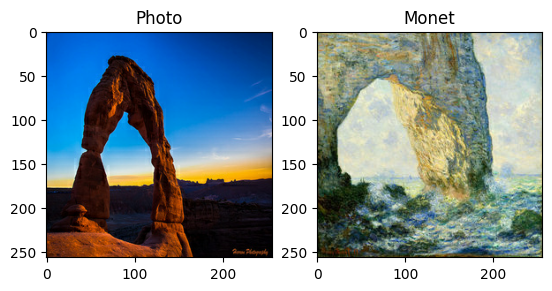

In [16]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(ex_p[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(ex_m[0] * 0.5 + 0.5)

# Model Architecture

## Downsample & Upsample
Implement `downsample` and `upsample` functions:
- **`downsample`**: Downsampling reduces the spatial dimensions of the input image, allowing the network to capture and extract hierarchical features at multiple scales, which decreases the number of computations required and makes it feasible to train deep networks with limited computational resources. As the spatial dimensions decrease, the receptive field of the network increases, allowing for more global context.
- **`upsample`**: Upsampling increases the spatial dimensions of the feature maps, reconstructing the original size of the input image. Fine details and high-frequency information need to be recovered to ensure the output image is visually plausible and retains the structure of the original image. 

We will be using [`Conv2d`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [`Conv2dTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) from Keras to accomplish this

In [17]:
def downsample(filters: int, size: int, apply_instancenorm: bool = True):
    """Downsamples an input: Conv2D => InstanceNorm => LeakyRelu
    
    Conv2d: This layer reduces the spatial resolution by half and applies a specified number of filters with a given kernel size
    InstanceNorm: A normalization layer that normalizes its inputs using the mean and variance of the current batch of inputs, if applied
    LeakyReLU: Introduces non-linearity and maintains gradient flow for negative inputs

    Args:
        filters (int): Number of filters for layer stack
        size (int): Kernel size
        apply_instancenorm (bool, optional): Apply a GroupNormalization? Defaults to True.

    Returns:
        stack: downsample stack layers using keras.Sequential
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    stack = keras.Sequential()
    stack.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        stack.add(layers.GroupNormalization(groups=-1))

    stack.add(layers.LeakyReLU())

    return stack

In [18]:
def upsample(filters: int, size: int, apply_dropout: bool = True):
    """Upsamples an input: Conv2DTranspose => InstanceNorm => Dropout => Relu
    
    Conv2DTranspose: This layer increases the spatial resolution by a factor of 2 and applies a specified number of filters with a given kernel size.
    GroupNormalization: A normalization layer that normalizes the activations across the feature maps
    Dropout: A regularization layer that applies dropout to the input
    ReLU: Introduces non-linearity and maintains gradient flow for positive inputs

    Args:
        filters (int): Number of filters for layer stack
        size (int): Kernel size
        apply_dropout (bool, optional): _description_. Defaults to False.

    Returns:
        stack: upsample stack using keras.Sequential
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    stack = keras.Sequential()
    stack.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    stack.add(layers.GroupNormalization(groups=-1))
    
    if apply_dropout:
        stack.add(layers.Dropout(0.5))

    stack.add(layers.ReLU())

    return stack

# Generator

In [19]:
def build_generator():
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [20]:
class Generator():
    def __init__(self) -> keras.Model:
        """Builds the generator model.

        Returns:
            (keras.model): Generator model
        """
        self.inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS])

        # bs = batch size
        self.down_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
            self.downsample(128, 4, apply_instancenorm=True), # (bs, 64, 64, 128)
            self.downsample(256, 4, apply_instancenorm=True), # (bs, 32, 32, 256)
            self.downsample(512, 4, apply_instancenorm=True), # (bs, 16, 16, 512)
            self.downsample(512, 4, apply_instancenorm=True), # (bs, 8, 8, 512)
            self.downsample(512, 4, apply_instancenorm=True), # (bs, 4, 4, 512)
            self.downsample(512, 4, apply_instancenorm=True), # (bs, 2, 2, 512)
            self.downsample(512, 4, apply_instancenorm=True), # (bs, 1, 1, 512)
        ]

        self.up_stack = [
            self.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            self.upsample(512, 4, apply_dropout=False), # (bs, 16, 16, 1024)
            self.upsample(256, 4, apply_dropout=False), # (bs, 32, 32, 512)
            self.upsample(128, 4, apply_dropout=False), # (bs, 64, 64, 256)
            self.upsample(64, 4, apply_dropout=False), # (bs, 128, 128, 128)
        ]

        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=self.initializer,
                                    activation='tanh') # (bs, 256, 256, 3)

        self.x = self.inputs

        # Downsampling through the model
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = layers.Concatenate()([x, skip])

        x = self.last(x)
        
        self.model = keras.Model(inputs=self.inputs, outputs=x)

        # return self.model
    
    def downsample(filters: int, size: int, apply_instancenorm: bool):
        """Downsamples an input. Conv2D => InstanceNorm => LeakyRelu

        Args:
            filters (int): Number of filters for layer stack
            size (int): Kernel size
            apply_instancenorm (bool, optional): Apply a GroupNormalization? Defaults to True.

        Returns:
            _type_: _description_
        """
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

        if apply_instancenorm:
            result.add(layers.GroupNormalization(groups=-1))

        result.add(layers.LeakyReLU())

        return result
    
    def upsample(filters: int, size: int, apply_dropout: bool):
        """Upsamples an input. Conv2DTranspose => InstanceNorm => Dropout => Relu

        Args:
            filters (int): Number of filters for layer stack
            size (int): Kernel size
            apply_dropout (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: Keras sequential model
        """
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

        result.add(layers.GroupNormalization(groups=-1))
        
        if apply_dropout:
            result.add(layers.Dropout(0.5))

        result.add(layers.ReLU())

        return result
    

In [21]:
def generator_example(photo):
    """Generates an example photo.

    Args:
        photo (): _description_
    """
    monet_generator = build_generator()
    monet = monet_generator(photo)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(photo[0] * 0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.title("Monet")
    plt.imshow(monet[0] * 0.5 + 0.5)
    plt.show()

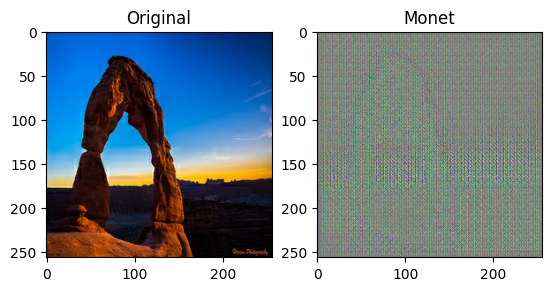

In [22]:
example = generator_example(ex_p)

# Discriminator

In [23]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = layers.GroupNormalization(groups=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [24]:
class Discriminator():
    def __init__(self) -> keras.Model:
        """Builds the discriminator model.

        Returns:
            (keras.model): discriminator model
        """
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        self.inp = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

        self.x = self.inp

        self.down1 = self.downsample(64, 4, apply_instancenorm=False)(self.x) 
        self.down2 = self.downsample(128, 4, apply_instancenorm=True)(self.down1) 
        self.down3 = self.downsample(256, 4, apply_instancenorm=True)(self.down2) 

        self.zero_pad1 = layers.ZeroPadding2D()(self.down3) 
        self.conv = layers.Conv2D(512, 4, strides=1,
                            kernel_initializer=self.initializer,
                            use_bias=False)(self.zero_pad1) 

        self.norm1 = layers.GroupNormalization(groups=-1)(self.conv)

        self.leaky_relu = layers.LeakyReLU()(self.norm1)

        self.zero_pad2 = layers.ZeroPadding2D()(self.leaky_relu) 

        self.last = layers.Conv2D(1, 4, strides=1,
                            kernel_initializer=self.initializer)(self.zero_pad2) 

        self.model = tf.keras.Model(inputs=self.inp, outputs=self.last)

        # return self.model
    
    def downsample(filters: int, size: int, apply_instancenorm: bool):
        """Downsamples an input. Conv2D => InstanceNorm => LeakyRelu

        Args:
            filters (int): Number of filters for layer stack
            size (int): Kernel size
            apply_instancenorm (bool, optional): Apply a GroupNormalization? Defaults to True.

        Returns:
            _type_: _description_
        """
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

        if apply_instancenorm:
            result.add(layers.GroupNormalization(groups=-1))

        result.add(layers.LeakyReLU())

        return result

# Model Construction

## Initialize Generators
Create the generators and discriminators to apply to the CycleGAN Class. Also generate a sample photo

In [25]:
monet_generator = build_generator() 
photo_generator = build_generator() 

monet_discriminator = build_discriminator() 
photo_discriminator = build_discriminator() 

In [26]:
def generate_example(photo):
    """Generates an example photo.

    Args:
        photo (): _description_
    """
    monet = monet_generator(photo)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(photo[0] * 0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.title("Monet")
    plt.imshow(monet[0] * 0.5 + 0.5)
    plt.show()

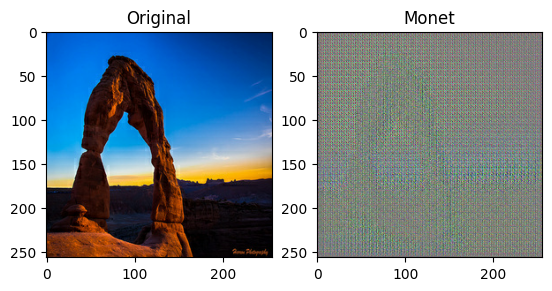

In [27]:
example = generate_example(ex_p)

## CycleGAN Model Class
Construct the model class

In [38]:
class CycleGAN(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, cycle=10):
        """Initializes the CycleGAN model.

        Args:
            monet_generator (generator object): Monet generator
            photo_generator (generator object): Photo generator
            monet_discriminator (discriminator object): Monet discriminator
            photo_discriminator (discriminator): Photo discriminator
            cycle (int, optional): Lambda. Defaults to 10.
        """
        super(CycleGAN, self).__init__()
        self.generator_monet = monet_generator
        self.generator_photo = photo_generator
        self.discriminator_monet = monet_discriminator
        self.discriminator_photo = photo_discriminator
        # self.generator_monet = build_generator()
        # self.generator_photo = build_generator()
        # self.discriminator_monet = build_discriminator()
        # self.discriminator_photo = build_discriminator()
        self.cycle = cycle
        
    def compile(self, generator_monet_optimizer, generator_photo_optimizer, discriminator_monet_optimizer, 
                discriminator_photo_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        """Compiles the CycleGAN model.

        Args:
            generator_monet_optimizer (_type_): _description_
            generator_photo_optimizer (_type_): _description_
            discriminator_monet_optimizer (_type_): _description_
            discriminator_photo_optimizer (_type_): _description_
            gen_loss_fn (_type_): _description_
            disc_loss_fn (_type_): _description_
            cycle_loss_fn (_type_): _description_
            identity_loss_fn (_type_): _description_
        """
        super(CycleGAN, self).compile()
        self.generator_monet_optimizer = generator_monet_optimizer
        self.generator_photo_optimizer = generator_photo_optimizer
        self.discriminator_monet_optimizer = discriminator_monet_optimizer
        self.discriminator_photo_optimizer = discriminator_photo_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        """Trains the model.

        Args:
            batch_data (_type_): _description_

        Returns:
            _type_: _description_
        """
        real_m, real_p = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_m = self.generator_monet(real_p, training=True)
            cycled_p = self.generator_photo(fake_m, training=True)

            # monet to photo back to monet
            fake_p = self.generator_photo(real_m, training=True)
            cycled_m = self.generator_monet(fake_p, training=True)

            # generating itself
            same_m = self.generator_monet(real_m, training=True)
            same_p = self.generator_photo(real_p, training=True)

            # discriminator used to check, inputing real images
            disc_real_m = self.discriminator_monet(real_m, training=True)
            disc_real_p = self.discriminator_photo(real_p, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_m = self.discriminator_monet(fake_m, training=True)
            disc_fake_p = self.discriminator_photo(fake_p, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_m)
            photo_gen_loss = self.gen_loss_fn(disc_fake_p)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_m, cycled_m, self.cycle) + self.cycle_loss_fn(real_p, cycled_p, self.cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_m, same_m, self.cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_p, same_p, self.cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_m, disc_fake_m)
            photo_disc_loss = self.disc_loss_fn(disc_real_p, disc_fake_p)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.generator_monet.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.generator_photo.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.discriminator_monet.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.discriminator_photo.trainable_variables)

        # Apply the gradients to the optimizer
        self.generator_monet_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.generator_monet.trainable_variables))

        self.generator_photo_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.generator_photo.trainable_variables))

        self.discriminator_monet_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.discriminator_monet.trainable_variables))

        self.discriminator_photo_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.discriminator_photo.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
        
    def discriminator_loss(self, real, generated):
        """Calculates the discriminator loss.

        Args:
            real (_type_): _description_
            generated (_type_): _description_

        Returns:
            loss: Discriminator loss
        """
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(self, generated):
        """Calculates the generator loss.

        Args:
            generated (_type_): _description_

        Returns:
            loss: Generator loss
        """
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(self, real_image, cycled_image, LAMBDA):
        """Calculates the cycle consistency loss.

        Args:
            real_image (_type_): _description_
            cycled_image (_type_): _description_
            LAMBDA (_type_): _description_

        Returns:
            loss: Cycle consistency loss
        """
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(self, real_image, same_image, LAMBDA):
        """Calculates the identity loss.

        Args:
            real_image (_type_): _description_
            same_image (_type_): _description_
            LAMBDA (_type_): _description_

        Returns:
            loss: Identity loss
        """
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
    def cgan_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
        """Optimizer for the CycleGAN model. Will be used for all optimizers and using Adam.

        Args:
            epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
            beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

        Returns:
            opmitizer: Optimized generator
        """
        return tf.keras.optimizers.Adam(epsilon, beta_1)
    
    def monet_generator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
        """Monet generator optimizer.

        Args:
            epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
            beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

        Returns:
            opmitizer: Optimized generator
        """
        return tf.keras.optimizers.Adam(epsilon, beta_1)
        
    def photo_generator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
        """Photo generator optimizer.

        Args:
            epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
            beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

        Returns:
            opmitizer: Optimized generator
        """
        return tf.keras.optimizers.Adam(epsilon, beta_1)

    def monet_discriminator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
        """Monet discriminator optimizer.

        Args:
            epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
            beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

        Returns:
            opmitizer: Optimized discriminator
        """
        return tf.keras.optimizers.Adam(epsilon, beta_1)
    
    def photo_discriminator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
        """Photo discriminator optimizer.

        Args:
            epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
            beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

        Returns:
            opmitizer: Optimized discriminator
        """
        return tf.keras.optimizers.Adam(epsilon, beta_1)

## Train CycleGAN
Training `cgan`

In [39]:
cgan = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

In [40]:
cgan.compile(
    generator_monet_optimizer = cgan.cgan_optimizer,
    generator_photo_optimizer = cgan.cgan_optimizer,
    discriminator_monet_optimizer = cgan.cgan_optimizer,
    discriminator_photo_optimizer = cgan.cgan_optimizer,
    gen_loss_fn = cgan.generator_loss,
    disc_loss_fn = cgan.discriminator_loss,
    cycle_loss_fn = cgan.calc_cycle_loss,
    identity_loss_fn = cgan.identity_loss
)

In [41]:
cgan.summary()

Model: "cycle_gan_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_33 (Functional)      │ ?                      │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_50 (Functional)      │ ?                      │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_55 (Functional)      │ ?                      │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_60 (Functional)      │ ?                      │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = cgan.fit(
    gan_dataset(monet_tfrec, photo_tfrec, batch_size=BATCH_SIZE), 
    steps_per_epoch=(max(len(monet_tfrec), len(photo_tfrec))//4),
    epochs=EPOCHS
).history 

Epoch 1/4


AttributeError: 'function' object has no attribute 'apply_gradients'

# Results & Analysis

In [43]:
def visualize_results(images: int):
    _, ax = plt.subplots(images, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.take(images)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

2024-06-23 13:16:03.623705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


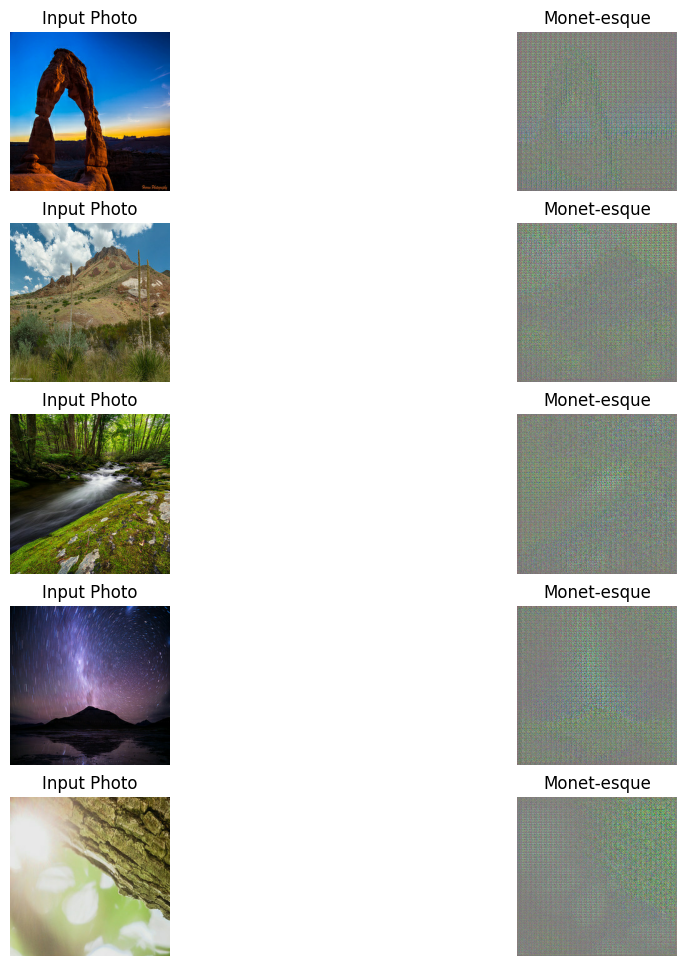

In [44]:
visualize_results(5)

# Test Model

In [ ]:
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Conclusion